In [1]:
import random
from numpy import random as nprd
import tensorflow as tf
tf.random.set_seed(42)
random.seed(42)
nprd.seed(42)

In [2]:
!pip install pyppeteer

     |████████████████████████████████| 83 kB 1.6 MB/s 
     |████████████████████████████████| 103 kB 38.4 MB/s 
     |████████████████████████████████| 138 kB 82.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import asyncio
import re
import csv
import pyppeteer as ptr
import pandas as pd
import nltk
from typing import Optional, TypeVar
from typing import Callable
from glob import glob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [6]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
resource_path = "/content/drive/MyDrive/resources/"

data_path = resource_path + "data/"
data_source_path = data_path + "sources"
data_target_path = data_path + "targets"

In [9]:
from typing import List, Tuple
PosTag = Tuple[str, str]
PosTagList = List[PosTag]
StemWord = str
StemWordList = List[StemWord]

In [10]:
global_config = {
    "word_limit": 56,
    "n_samples": 1000,
    "test_size": 0.4
}

In [11]:
def get_name_and_extension(file_path: str) -> Tuple[str, str]:
    regex = re.compile(r"(.*)/(.*)\.(.*)")
    return regex.match(file_path).group(2,3)

In [12]:
!pip install nest_asyncio
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 94.0 MB of archives.
After this operation, 324 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 95.0.4638.69-0ubuntu0.18.04.1 [1,135 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 95.0.4638.69-0ubuntu0.18.04.1 [83.6 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser-l10n all 95.0.4638.69-0ubuntu0.18.0

In [13]:
!dpkg -L chromium-chromedriver

/.
/usr
/usr/bin
/usr/bin/chromedriver
/usr/lib
/usr/lib/chromium-browser
/usr/share
/usr/share/doc
/usr/share/doc/chromium-chromedriver
/usr/share/doc/chromium-chromedriver/copyright
/usr/lib/chromium-browser/chromedriver
/usr/share/doc/chromium-chromedriver/changelog.Debian.gz


In [14]:
async def download_html(browser: ptr.browser.Browser, page: ptr.page.Page, url: str, selector: str) -> Optional[str]:
    await page.goto(url, waitUntil="load", timeout=0)
    content = await page.querySelector(selector)

    html = ''
    if content:
        html = await page.evaluate('(element) => element.textContent', content)
        
    return html

def write_to_resource_target(target_path: str, file_name: str, content: StemWordList, extension="txt") -> None:
    with open(f"{target_path}/{file_name}.{extension}", "w") as file:
        file.write("\n".join(content))


async def get_training_data_from_folder(source_path: str, target_path: str, force=False) -> None:
    browser = await ptr.launch(headless=True, executable_path="/usr/lib/chromium-browser/chromedriver", options={'args': ['--no-sandbox']})
    page = await browser.newPage()
    
    glob_pattern = "/**/*"
    source_files = glob(source_path + glob_pattern, recursive=True)
    target_files = glob(target_path + glob_pattern, recursive=True)
    target_file_names = [get_name_and_extension(file_path)[0] for file_path in target_files]
    
    for file_path in source_files:
        [file_name, file_extension] = get_name_and_extension(file_path)
        
        if not file_name in target_file_names or force:
            result = await get_training_data(browser, page, file_path)
            write_to_resource_target(target_path, file_name, result)        
                
    await browser.close()

async def get_training_data(browser: ptr.browser.Browser, page: ptr.page.Page, file_path: str) -> StemWordList:
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    words = []
    if isinstance(df, pd.DataFrame):
        for _, row in df.iterrows():
            result = await download_html(browser, page, row["link"], row["selector"])
            words.extend(clean_up_words(tokenize(result)))
    
    return words

In [15]:
T = TypeVar("T")
R = TypeVar("R")

TestValueStrCallable = Callable[[T], str]
TestValueBoolCallable = Callable[[T], bool]
ValueTestFnCallable = Callable[[T], TestValueStrCallable]
FilterCallable = Callable[[ValueTestFnCallable], bool]
MapCallable = Callable[[ValueTestFnCallable], str]

def tokenize(data: str) -> PosTagList:
    tokenized_words = nltk.word_tokenize(data)
    mutated_words = nltk.pos_tag(tokenized_words)
    return mutated_words

def filter_words(x: T, test_value: TestValueStrCallable, *fns: FilterCallable) -> bool:
    if fns:
        if fns[0](x, test_value):
            return filter_words(x, test_value, *fns[1:])
        else:
            return False
    
    return True
    
def filter_by_punctuation(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
    return x[0] != x[1]

def filter_by_stop_word(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
    return test_value(x) not in stopwords.words("english")

def regex_filter(regex: str):
    def filter_by_regex(x: T, test_value: TestValueStrCallable = lambda t: t[0]):
        rgx = re.compile(regex)
        return rgx.match(test_value(x))
    return filter_by_regex

filter_by_alphabet = regex_filter(r"^([a-zA-Z]|')+$")
filter_by_apostrophe = regex_filter(r"^[^']*$")

def map_by_stem_words(x: PosTag, test_value: TestValueStrCallable = lambda t: t[0], ps=PorterStemmer()) -> StemWord:
    return ps.stem(test_value(x)).lower()

def map_words(x: T, test_value: TestValueStrCallable, *fns: MapCallable) -> StemWord:
    if fns:
        return map_words(fns[0](test_value(x)), test_value, *fns[1:])

    return x
            
def clean_up_words(words: PosTagList) -> StemWordList:
    filtered_words = list(
        filter(
        lambda x: filter_words(x, lambda x: x[0], filter_by_punctuation, filter_by_stop_word, filter_by_alphabet),
        words
        )
    )

    stem_words = list(map(lambda x: map_words(x, lambda x: x, map_by_stem_words), filtered_words))
    
    return list(
        filter(
            lambda x: filter_words(x, lambda x: x, filter_by_apostrophe), 
            stem_words)
    )

In [16]:
import nest_asyncio
nest_asyncio.apply()

In [17]:
# type: ignore
#asyncio.run(get_training_data_from_folder(resource_source_path, resource_target_path))

In [18]:
from typing import Dict

def get_cleaned_data_from_file(input_file_path: str) -> Optional[List[str]]:
    with open(input_file_path, "r") as file:
        return [word.strip("\n") for word in list(file.readlines())]

def get_cleaned_data_from_folder(input_path: str) -> Dict[str, PosTagList]:
    glob_pattern = "/**/*"
    input_files = glob(input_path + glob_pattern, recursive=True)
    
    data = dict()
    for file_path in input_files:
        [file_name, file_extension] = get_name_and_extension(file_path)
        classification_data = get_cleaned_data_from_file(file_path)
        data[file_name] = classification_data
        
    return data

def group_by_tags(pos_tag_list: PosTagList) -> Dict[str, List[str]]:
    """
      @unused
    """
    groups = dict()
    
    for value,tag in pos_tag_list:
        if tag in groups:
            groups[tag]
            groups[tag].append(value)
        else:
            groups[tag] = [value]
            
    return groups

In [19]:
from nltk.probability import WittenBellProbDist, FreqDist,LaplaceProbDist
import numpy as np

def unpack_dict_list(dict_list: Dict[str, StemWordList]):
    return [v for k in dict_list for v in dict_list[k]]

def generate_sample(population: StemWordList, label: str, n_unique_words: int, word_limit = global_config["word_limit"]):
    freq_dist = FreqDist(population)
    prob_dist = WittenBellProbDist(freq_dist, n_unique_words)
    
    samples = [prob_dist.generate() for _ in range(word_limit)]

    return np.array(list([*samples, label])).reshape(-1, 1)

def generate_samples(data: Dict[str, StemWordList], n_samples = global_config["n_samples"]):
    n_unique_words = len(set(unpack_dict_list(data)))
    
    return np.array([np.array([generate_sample(data[k], k, n_unique_words) for _ in range(n_samples)]) for k in data])

In [20]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from typing import Union

def get_one_hot_encoder(population: Dict[str, StemWordList]):
    population_array = np.array(list(set(unpack_dict_list(population)))).reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(population_array)
    return encoder

def get_label_encoder(labels: np.ndarray):
    encoder = LabelBinarizer()
    encoder.fit(labels)
    return encoder

def transform_data_by_encoder(data: np.ndarray, encoder: Union[OneHotEncoder, LabelBinarizer]):
    encoded_data = encoder.transform(data)
    
    if not isinstance(encoded_data, np.ndarray):
        encoded_data = encoded_data.toarray()
        
    return encoded_data

def split_into_x_y(samples: np.ndarray):
    x = samples[:,:,:-1]
    y = samples[:,:,-1]
    y = y.reshape(y.shape[0]*y.shape[1], 1)
    return (x,y)
    
def transform_x_y(x: np.ndarray, y: np.ndarray, in_coder: OneHotEncoder, out_coder: LabelBinarizer):   
    encoded_x = np.stack([
        transform_data_by_encoder(x[lbl_idx, smpl_idx], in_coder)
        for lbl_idx in range(x.shape[0])
        for smpl_idx in range(x.shape[1])
    ], axis=0)
            
    encoded_y = transform_data_by_encoder(y, out_coder)
    
    return (encoded_x, encoded_y)


In [21]:
import pickle

model_path = resource_path + "models/"
input_encoder_file_name = "input_encoder.pickle"
output_encoder_file_name = "output_encoder.pickle"

def get_x_y(path = data_target_path, n_samples=2000):
    result = get_cleaned_data_from_folder(data_target_path)
    samples = generate_samples(result, n_samples)
    x,y = split_into_x_y(samples)

    encoder_paths = glob(model_path + "*.pickle", recursive=True)
    encoder_file_names = [get_name_and_extension(file_path)[0] for file_path in encoder_paths]

    if input_encoder_file_name in encoder_file_names:
      input_encoder = pickle.load(open(encoder_paths[encoder_file_names.index(input_encoder_file_name)], "rb"))
    else:
      input_encoder = get_one_hot_encoder(result)

    if output_encoder_file_name in encoder_file_names:
      output_encoder = pickle.load(open(encoder_paths[encoder_file_names.index(output_encoder_file_name)], "rb"))
    else:
      output_encoder = get_label_encoder(y)

    pickle.dump(input_encoder, open(model_path + input_encoder_file_name, "wb"))
    pickle.dump(output_encoder, open(model_path + output_encoder_file_name, "wb"))

    return transform_x_y(x, y, input_encoder, output_encoder)

In [22]:
def get_data(n_samples=global_config["n_samples"], test_size=global_config["test_size"], random_state=42):
    x, y = get_x_y(n_samples=n_samples)
    x=x.reshape((*x.shape, 1))
    return train_test_split(x, y, test_size=test_size, random_state=random_state)

x_train, x_test, y_train, y_test = get_data()

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers, activations

history_path = model_path + "history.npy"
def save_history(history: np.ndarray):
  np.save(history_path, history, allow_pickle=True)

def load_history() -> Dict:
  return np.load(history_path, allow_pickle=True).item()

def run():
    input_shape = x_train.shape[1:]
    vocab_size = input_shape[-2]

    config = {}

    config["conv_layer_0"] = {
        "filters": 5 * vocab_size / 6,
        "kernel_size": (3, vocab_size),
        "strides": (1,1),
        "activation": "relu",
    }

    config["pool_layer_0"] = {
        "pool_size": (3,3),
        "padding": "same"
    }

    config["conv_layer_1"] = {
        "filters": 7 * config["conv_layer_0"]["filters"] / 16,
        "kernel_size": (2, 1),
        "strides": (1,1),
        "activation": "relu"
    }

    config["pool_layer_1"] = {
        "pool_size": (3,3),
        "padding": "same",
    }

    config["dense_layer_5"] = {
        "units": 16,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(0.6, 0.17)
    }

    config["dense_layer_6"] = {
        "units": 8,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(0.10, 0.18)
    }

    config["dense_layer_7"] = {
        "units": 4,
        "activation": "relu",
        # "kernel_regularizer": regularizers.l1_l2(0.1, 0.2),
        # "bias_regularizer": regularizers.l1_l2(0.1, 0.2)
    }

    config["dropout_layer_0"] = {
        "rate": 0.5,
    }

    config["dense_layer_8"]= {
        "units": 8,
        "activation": "relu",
        # "kernel_regularizer": regularizers.l1_l2(0.1, 0.2),
        # "bias_regularizer": regularizers.l1_l2(0.1, 0.2)
    }

    config["dropout_layer_1"]= {
        "rate": 0.33
    }

    config["flatten_layer_0"] = {
    }

    config["dense_layer_final"] = {
        "units": (y_train.shape[-1]),
        "activation": "softmax"
    }

    config["model_compile"] = {
        "optimizer": tf.keras.optimizers.Adam(0.001),
        "loss": keras.losses.binary_crossentropy,
        "metrics": ["accuracy", keras.metrics.Recall()]
    }

    config["model_fit"] = {
         "x": x_train,
         "y": y_train,
         "batch_size": 2,
         "epochs": 4,
         "validation_split" : global_config["test_size"]
    }

    encoder_input = keras.Input(shape=input_shape)
    prev_layer = encoder_input
    encoder_output=None

    layer_types = {
        "dense": layers.Dense,
        "flatten": layers.Flatten,
        "dropout": layers.Dropout,
        "conv": layers.Conv2D,
        "pool": layers.MaxPool2D,
        "comp": None,
    }
    
    for k,v in config.items():
      type_of_layer, *_ = k.split("_")
      if type_of_layer != "model":
        encoder_output = layer_types[type_of_layer](**v)(prev_layer)
        prev_layer = encoder_output
    
    config["model"] = {
        "inputs": encoder_input,
        "outputs": encoder_output,
        "name": "encoder"
    }

    model = keras.Model(**config["model"])
    model.compile(**config["model_compile"])

    print(model.summary())
    
    history = model.fit(**config["model_fit"])
    save_history(history.history)

    test_scores = model.evaluate(x_test, y_test, verbose=2)

    return model    

In [ ]:
model = run()

In [66]:
def clean_up_user_input(sentence: str, word_limit=56):
  tokenized_words = tokenize(sentence)
  
  word = clean_up_words(tokenized_words)
  words_to_test = np.array(word).reshape(-1, 1)

  if not words_to_test.size:
    return np.array([])

  input_encoder = pickle.load(open(model_path + input_encoder_file_name, "rb"))

  encoded_data = transform_data_by_encoder(words_to_test, input_encoder) 
  difference = word_limit - encoded_data.shape[0]
  zero_array = np.zeros(encoded_data.shape[1])

  for _ in range(difference):
    encoded_data = np.append(encoded_data, [zero_array], axis=0)

  return encoded_data

In [67]:
import os

cnn_folder = "cnn"
cnn_path = model_path + cnn_folder

def save_cnn(override:bool=False, model=model):
  if not os.path.exists(cnn_path) or override:
    model.save(cnn_path)

save_cnn()

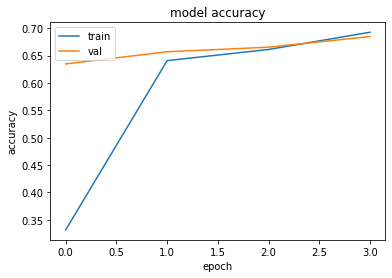

In [69]:
from keras import models
from matplotlib import pyplot as plt

def plot_cnn():
  history = load_history()
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_cnn()

In [75]:
def predict(sentence: str):
  word = clean_up_user_input(sentence)

  if word.size:
    word = word.reshape(*word.shape, 1)
    words = np.array([word])
    output_encoder: LabelBinarizer = pickle.load(open(model_path + output_encoder_file_name, "rb"))
    prediction = model.predict(words)
    prediction_binary = np.zeros_like(prediction)
    prediction_binary[:,prediction.argmax(1)] = 1
    print(prediction_binary)
    print(prediction)
    print(output_encoder.inverse_transform(prediction))

predict("I have a headache. I feel senstivity to light. My head is hurting. It's twirling. I feel an aura")

[[0. 1. 0.]]
[[0.21309918 0.4651584  0.32174242]]
['migraine']
